This is the 4th rank team solution for the Delivery Rider Response Challenge organzed by Zindi and Galsenai (2021).

Authors: Omar Badiane (omarbadiane1@outlook.com) and Emmanuel Siaw Darko (immanuelsiawdarko@gmail.com)


The objective of this challenge was to create a machine learning model that will predict whether a rider will accept, decline or ignore an order sent to them.

In [1]:
!unrar x -Y'/content/configs.rar' '/content/configs'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/configs.rar

Creating    configs                                                   OK
Extracting  configs/requirements.txt                                      28%  OK 
Extracting  configs/SendyConfig.yaml                                      89%  OK 
All OK


In [4]:
!unrar x -Y'/content/data.rar' '/content/data'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/data.rar

Creating    data                                                      OK
Extracting  data/Riders.csv                                                0%  OK 
Extracting  data/SampleSubmission.csv                                      6%  OK 
Extracting  data/Test.csv                                                 34%  OK 
Extracting  data/Train.csv                                                77% 99%  OK 
All OK


In [3]:
!pip install -q -r /content/configs/requirements.txt

In [5]:
from omegaconf import OmegaConf
# from zindi.user import Zindian
import numpy as np
import pandas as pd
import os
import shutil

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc,roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier ,Pool

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

import warnings
warnings.simplefilter('ignore')

In [6]:
config_ = OmegaConf.load('/content/configs/SendyConfig.yaml')

In [7]:
print(OmegaConf.to_yaml(config_.dir))

data_path: ./data/
train_file: ./data/Train.csv
riders_file: /content/data/Riders.csv
test_file: ./data/Test.csv
submit_file: ./data/SampleSubmission.csv
model_path: ./models/
checkpoints_path: ./checkpoints/
predictions_path: ./submissions/



In [8]:
os.makedirs(config_.dir.model_path , exist_ok=True )
os.makedirs(config_.dir.predictions_path, exist_ok=True)

In [9]:
print(OmegaConf.to_yaml(config_.defaults))

seed_value: 2021
nKfold: 10



In [10]:
# Setting SEED to Reproduce Same Results even with "GPU"
import os
os.environ['PYTHONHASHSEED'] = str(config_.defaults.seed_value)
import random
random.seed(config_.defaults.seed_value)
import numpy as np
np.random.seed(config_.defaults.seed_value)


In [11]:
print(OmegaConf.to_yaml(config_.dir))

data_path: ./data/
train_file: ./data/Train.csv
riders_file: /content/data/Riders.csv
test_file: ./data/Test.csv
submit_file: ./data/SampleSubmission.csv
model_path: ./models/
checkpoints_path: ./checkpoints/
predictions_path: ./submissions/



In [12]:
train_df = pd.read_csv(config_.dir.train_file)
test_df = pd.read_csv(config_.dir.test_file)
riders_df = pd.read_csv(config_.dir.riders_file)
sub_df = pd.read_csv(config_.dir.submit_file)

train = train_df.copy()
test = test_df.copy()
riders = riders_df.copy()

In [13]:
# Separate target variable 
target = train['target'].copy()

# Drop target column then join Train and test
train.drop('target',axis = 1, inplace = True)

In [14]:
# Merge the train and test dataframe
merged_df = [train,test]
df = pd.concat(merged_df)

We would like to acknowledge Mburia for the preprocessing steps on conditions used and the columns they helped generate as well as the bearing function used in calculating the distance. [Source](https://github.com/Mburia/2nd-Place-Solution-UmojaHack_2021-Sendy)

Further features we created including session_Late Night, session_Early Morning ,session_Morning, Session_Noon,session_Eve and session_Night  helped inform us of period within the data, the dispatch was being done

In [15]:
# Calculate distance between coordinates

def distance_calc(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    AVG_EARTH_RADIUS = 6371  # in km
    
    lat = lat2 - lat1
    
    lng = lng2 - lng1
    
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h

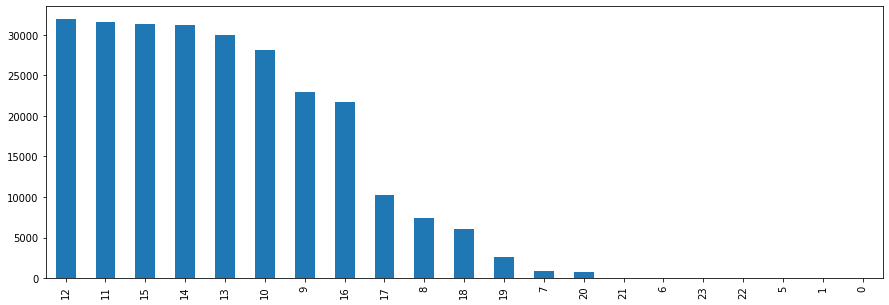

In [16]:
# create a list of our conditions
conditions1 = [
    (df['rider_amount'] <= 390),
    (df['rider_amount'] > 390) & (df['rider_amount'] <= 650),
    (df['rider_amount'] > 650) & (df['rider_amount'] <= 820),
    (df['rider_amount'] > 800) & (df['rider_amount'] <= 1200)
    ]

# create a list of our conditions
conditions2 = [
    (df['dispatch_day'] == 1),
    (df['dispatch_day'] > 1) & (df['dispatch_day'] <= 6),
    (df['dispatch_day'] > 6) & (df['dispatch_day'] <= 8),
    (df['dispatch_day'] >8)
    ]

conditions3 = [
    (df['dispatch_day_of_week'] == 1),
    (df['dispatch_day_of_week'] == 7)
    ]

# create a list of the values we want to assign for each condition
values1 = ['2', '4', '3', '1']
values2 = ['1', '2','3','4']
values3 = ['2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_amount_range'] = np.select(conditions1, values1)
df['dispatch_day_range'] = np.select(conditions2, values2)
df['weekend'] = np.select(conditions3, values3)

# Convert time column to datetime
df['dispatch_time'] = pd.to_datetime(df['dispatch_time'])

# Extract Hour Column
df['dispatch_hour'] = df['dispatch_time'].dt.hour

# Let's view the hourly distribution of dispatches
df['dispatch_hour'].value_counts().plot(kind='bar',figsize=[15,5])

In [17]:
# Let's get the cos and cosine of our Time Variable
time_column = ["dispatch_time"]

for col in time_column:
  df[col.split('_')[0] + '_hour_sine'] = np.sin(2 * np.pi * df[col].dt.hour/24)
  df[col.split('_')[0] + '_hour_cos'] = np.cos(2* np.pi * df[col].dt.hour/24)

  # 4th condition
conditions4 = [
    (df['dispatch_hour'] <= 6),
    (df['dispatch_hour'] > 8) & (df['dispatch_hour'] <= 16),
    (df['dispatch_hour'] > 16) & (df['dispatch_hour'] <= 20),
    (df['dispatch_hour'] > 20)
    ]

# value for 4th condition
values4 = ['1', '4', '3', '2']

# create a new column and use np.select to assign values to it using our lists as arguments
df['busy_hours'] = np.select(conditions4, values4)

In [18]:
# Let's create variables for the distances between the locations of the riders, pickup points and dropoff points
df['rider_dropoff_dist'] = distance_calc(df.rider_lat, df.rider_long, df.drop_off_lat, df.drop_off_long)
df['rider_pickup_dist'] = distance_calc(df.rider_lat, df.rider_long, df.pickup_lat, df.pickup_long)
df['pickup_dropoff_dist'] = distance_calc(df.pickup_lat, df.pickup_long, df.drop_off_lat, df.drop_off_long)

# 5th condition
conditions5 = [
    (df['pickup_dropoff_dist'] <= 6),
    (df['pickup_dropoff_dist'] > 6) & (df['pickup_dropoff_dist'] <= 16),
    (df['pickup_dropoff_dist'] > 16) & (df['pickup_dropoff_dist'] <= 30),
    (df['pickup_dropoff_dist'] > 30) & (df['pickup_dropoff_dist'] <= 50),
    (df['pickup_dropoff_dist'] > 50)
    ]
conditions6 = [
    (df['rider_pickup_dist'] <= 1),
    (df['rider_pickup_dist'] > 1) & (df['rider_pickup_dist'] <= 1.5),
    (df['rider_pickup_dist'] > 1.5) & (df['rider_pickup_dist'] <= 2.5),
    (df['rider_pickup_dist'] > 2.5) & (df['rider_pickup_dist'] <= 3.7),
    (df['rider_pickup_dist'] > 3.7)
    ]
conditions7 = [
    (df['rider_dropoff_dist'] <= 5),
    (df['rider_dropoff_dist'] > 5) & (df['rider_dropoff_dist'] <= 10),
    (df['rider_dropoff_dist'] > 10) & (df['rider_dropoff_dist'] <= 18),
    (df['rider_dropoff_dist'] > 18) & (df['rider_dropoff_dist'] <= 30),
    (df['rider_dropoff_dist'] > 30)
    ]
values5 = ['5','4', '3', '2', '1']
values6 = ['1', '2', '3', '4','5']
values7 = ['1', '2', '3', '4','5']

df['pickup_dropoff_dist_range'] = np.select(conditions5, values5)
df['rider_pickup_dist_range'] = np.select(conditions6, values6)
df['rider_dropoff_dist_range'] = np.select(conditions7, values7)

#for the
conditions8 = [
    (df['rider_dropoff_dist_range'] == '5') & (df['busy_hours'] == '1'),
    (df['rider_dropoff_dist_range'] == '4') & (df['busy_hours'] == '2'),
    (df['rider_dropoff_dist_range'] == '3') & (df['busy_hours'] == '3'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '1') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '0')
    ]
values8 = ['1', '2', '3', '4','6','5']
df['time_distance_bias'] = np.select(conditions8, values8)

conditions9 = [
    (df['dispatch_day_of_week'] == '1') & (df['time_distance_bias'] == '5'), # Sunday  early morning & average distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '3'), # Saturday late night & long distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '5'), # Saturday early morning average distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '3'), # Weekday late night & long distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '6')  # Weekday daytime and average distance
    ]

conditions10 = [
    (df['rider_amount_range'] == '4') & (df['busy_hours'] == '4'),
    (df['rider_pickup_dist_range'] == '3') & (df['busy_hours'] == '2'),
    (df['rider_pickup_dist_range'] == '1') & (df['rider_amount_range'] == '4'),
    (df['rider_pickup_dist_range'] == '4') & (df['rider_amount_range'] == '4')
    ]
# values for 5th & 6th conditions


values9 = ['1', '2', '3', '4','5']
values10 = ['4','2','6','1']

# create a new column and use np.select to assign values to it using our lists as arguments


df['weekend_time_distance_bias'] = np.select(conditions9, values9)
df['money_distance_bias'] = np.select(conditions10, values10)

In [19]:
# let's convert some string columns to numeric
df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']] = df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']].apply(pd.to_numeric)

In [20]:
df['hour'] = pd.to_datetime(df['dispatch_time'], format='%H:%M:%S').dt.hour


b = [0,4,8,12,16,20,24]

l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']

df['session'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)

# One hot encoding

df = pd.get_dummies(df, columns=['session'])

In [21]:
# Split train and test set
train = df.iloc[:179867, :]
test = df.iloc[179867:, :]

In [22]:
# Selecting the columns to be used as data for accuracy testing
cols = [col for col in train.columns if col not in config_.preprocessing.to_drop]

assert cols==config_.preprocessing.mod_cols
assert (train[cols].values == train[config_.preprocessing.mod_cols].values).all()

# Set the target and independent variables
X = train[config_.preprocessing.mod_cols]
y = target

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179867 entries, 0 to 179866
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    179867 non-null  int64  
 1   dispatch_day                179867 non-null  int64  
 2   dispatch_day_of_week        179867 non-null  int64  
 3   client_id                   179867 non-null  int64  
 4   client_type                 179867 non-null  object 
 5   order_license_status        179867 non-null  int64  
 6   order_carrier_type          179867 non-null  int64  
 7   vendor_type                 179867 non-null  object 
 8   rider_id                    179867 non-null  int64  
 9   rider_license_status        179867 non-null  int64  
 10  rider_carrier_type          179867 non-null  int64  
 11  rider_amount                179867 non-null  int64  
 12  rider_lat                   179867 non-null  float64
 13  rider_long    

In [24]:
print(OmegaConf.to_yaml(config_.catboostmodel))

random_seed: 2021
learning_rate: 0.099
iterations: 2000
early_stopping_rounds: 50



In [25]:
# Fitting the data to model
from catboost import CatBoostClassifier

# You can increase the iterations parameter but it will take longer to learn
cb_model = CatBoostClassifier(**config_.catboostmodel )

In [26]:
# Here we fit our data then make predictions
# Since Catboost accepts categorical features we'll make then identifiable to the model 
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Fitting our data to the model
cb_model.fit(X,y,cat_features=categorical_features_indices)

0:	learn: 1.0583518	total: 2.21s	remaining: 1h 13m 45s
1:	learn: 1.0256801	total: 4.36s	remaining: 1h 12m 34s
2:	learn: 0.9992827	total: 6.41s	remaining: 1h 11m 4s
3:	learn: 0.9772538	total: 8.42s	remaining: 1h 10m 2s
4:	learn: 0.9500128	total: 10.3s	remaining: 1h 8m 46s
5:	learn: 0.9281333	total: 12.5s	remaining: 1h 9m 9s
6:	learn: 0.9100512	total: 14.5s	remaining: 1h 8m 38s
7:	learn: 0.8936838	total: 16.2s	remaining: 1h 7m 13s
8:	learn: 0.8801962	total: 18.4s	remaining: 1h 7m 40s
9:	learn: 0.8645087	total: 20.4s	remaining: 1h 7m 48s
10:	learn: 0.8507676	total: 22.6s	remaining: 1h 8m 11s
11:	learn: 0.8391947	total: 24.5s	remaining: 1h 7m 30s
12:	learn: 0.8291371	total: 26.3s	remaining: 1h 7m 1s
13:	learn: 0.8210897	total: 28.7s	remaining: 1h 7m 46s
14:	learn: 0.8127889	total: 30.7s	remaining: 1h 7m 47s
15:	learn: 0.8061708	total: 33.1s	remaining: 1h 8m 26s
16:	learn: 0.7966125	total: 35.2s	remaining: 1h 8m 23s
17:	learn: 0.7895247	total: 37.1s	remaining: 1h 8m 5s
18:	learn: 0.7830496	

In [27]:
joblib.dump(cb_model, config_.dir.model_path+'cbmodel.joblib')

['./models/cbmodel.joblib']

In [28]:
# Making Predictions
y_pred = cb_model.predict(test[cols])

# Let's create a submission file to input our predictions
submissionFile= pd.DataFrame({"ID":test["ID"]})
submissionFile['target'] = y_pred

# Saving our data in a CSV
submissionFile.to_csv(config_.dir.predictions_path+"Sess00992000verify.csv",index=False)